In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from IPython.display import display, HTML

In [28]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Training Runs 

In [30]:
%tensorboard --logdir checkpoints

Reusing TensorBoard on port 6006 (pid 16000), started 5:12:33 ago. (Use '!kill 16000' to kill it.)

# Results on SNLI and SentEval Tasks
## SNLI

In [4]:
from evaluation.visualization import results_loader

results_loader(version=3, evaluation='snli')

,Train,Valid,Test
Baseline,62.3,60.9,61.1
Simple,85.9,81.3,80.2
BiSimple,91.0,81.7,81.1
BiMaxPool,94.9,84.1,84.3
BiLSTM-Max (SNLI)*,-,85.0,84.5


\* result from \[1] for comparison

The LSTM models quite clearly outperform the baseline, however, all show a significant generalization gap. Of all the models, the BiLSTM \w maxpooling works best.

The results are comparable to those of Conneau et al. \[1]

## SentEval
To change from macro to micro averaging, simply change the agg_method parameter to 'micro'. There is very little difference.

In [5]:
results_loader(version=3, evaluation='infersent', agg_method='macro')

,MR,CR,SUBJ,MPQA,SST2,TREC,MRPC,SICK-R,SICK-E,STS14
Macro Avg.,,,,,,,,,,
Baseline,75.0,71.6,88.8,86.7,78.2,64.2,69.8/80.3,0.627,63.5,.51/.53
Simple,66.2,71.3,75.8,85.8,70.7,54.5,70.5/80.3,0.785,79.9,.39/.42
BiSimple,67.6,72.3,77.1,86.8,71.1,49.7,70.1/79.9,0.775,79.3,.41/.43
BiMaxPool,79.7,84.4,92.1,89.7,80.1,84.2,75.5/82.8,0.891,85.7,.70/.67
BiLSTM-Max (SNLI)*,79.9,84.6,92.1,89.8,83.3,88.7,75.1/82.3,0.885,86.3,.68/.65


\* result from \[1] for comparison

On the SentEval tasks, however, the models are easily separable; the BiLSTM w\ maxpooling is the clear winner, scoring well above the baseline. Notably, the LSTM models tend to underperform, especially compared to the baseline. Generally, it also performs well. This goes to show how powerful general word embeddings are for encoding semantics. 

Again, the results are comparable to those of Conneau et al. \[1]

In [6]:
results_loader('3', evaluation='probing_all')

Surface          Syntax                 Semantics          \
                  SentLen    WC TreeDepth TopConst BShift     Tense SubjNum   
Baseline             79.1  31.4      30.8     45.6   55.7      84.7    78.1   
Simple               49.9  19.0      21.7     24.2   53.2      67.6    59.3   
BiSimple             49.5  25.3      22.3     24.0   55.5      70.3    60.2   
BiMaxPool            67.7  90.1      35.5     75.7   61.9      87.8    83.6   
BiLSTM-Max (NLI)*    71.7  87.3      41.6     70.5   65.1      86.7    80.7   
Human*               100   100       84.0     84.0   98.0      85.0    88.0   

                                         
                  ObjNum  SOMO CoordInv  
Baseline            75.6  54.6     55.9  
Simple              61.1  51.8     57.8  
BiSimple            61.8  54.9     59.6  
BiMaxPool           78.9  55.8     65.7  
BiLSTM-Max (NLI)*   80.3  62.1     66.8  
Human*              86.5  81.2     85.0

\* result from \[2] for comparison

Lastly, for some additional comparisons, I performed further evaluation on the SentEval probing tasks. Here the results are a little more dissapointing. Again, the LSTMs suffer on all tasks compared to baseline. The BiLSTM w\ maxpooling does perform better than baseline, but as the tasks go up the linguistic hierarchy, they start to suffer and approach the baseline scores again. A standout task for the BiLSTM w\ maxpooling is Word-Content classification, where it blows out the competition.

While the best comparison comes from a different paper trained on a different dataset (SNLI + MNLI), my implementation remain comparable to Conneau et al. \[2]

# Model Interaction
Loads the dataset, finds the vocab and generates the dataloaders.
For some reason this always takes a while.

In [7]:
import torch

from data.snli import SNLI

snli = SNLI()
snli.prep_data()
vocab = snli.vocab()

train_loader, valid_loader, test_loader = snli.snli_dataloaders(8, torch.device('cpu'))

print("Data loaded successfully.'")

Using dictionary with GloVe found at ./data/glove\snli_vocab.pt
Data loaded successfully.'


Load in the separate models
## Baseline

In [8]:
from models.InferSent import InferSent
from utils.reproducibility import load_latest

baseline = load_latest(pl_module=InferSent, save_name='InferSent-Baseline_v3', 
                       inference=True)
print(baseline)

Found pretrained model at ./checkpoints\InferSent-Baseline_v3\lightning_logs\version_7560180\checkpoints\epoch=2-step=25751.ckpt
InferSent(
  (embedding): Vocab_Embedding(
    (Embedding): Embedding(34155, 300)
  )
  (encoder): Baseline_Encoder()
  (classifier): InferSent_clf(
    (clf): Sequential(
      (0): Linear(in_features=1200, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=3, bias=True)
    )
  )
  (loss_module): CrossEntropyLoss()
)


## BiLSTM w/ Maxpool

In [9]:
from models.InferSent import InferSent
from utils.reproducibility import load_latest

maxpool = load_latest(pl_module=InferSent, save_name='InferSent-BiMaxPool_v3', 
                       inference=True)
print(maxpool)

Found pretrained model at ./checkpoints\InferSent-BiMaxPool_v3\lightning_logs\version_7560215\checkpoints\epoch=8-step=77255.ckpt
InferSent(
  (embedding): Vocab_Embedding(
    (Embedding): Embedding(34155, 300)
  )
  (encoder): MaxPoolLSTM_Encoder(
    (lstm): LSTM(300, 4096, bidirectional=True)
  )
  (classifier): InferSent_clf(
    (clf): Sequential(
      (0): Linear(in_features=32768, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=3, bias=True)
    )
  )
  (loss_module): CrossEntropyLoss()
)


## Interaction
### Some random examples
Here a batch is sampled for the training set (has nicer premises) for quick comparison.

In [10]:
batch = next(iter(train_loader))

In [11]:
from evaluation.visualization import input_output_table

input_output_table(batch.premise, batch.hypothesis, batch.label, baseline, vocab)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,there is one person on a racing motorcycle and one person on the ground .,there was an accident,2,0.210734,0.377024,0.412241,0.886146
1,a tennis player delivering his serve .,a tennis player is standing still .,1,0.366713,0.489203,0.144084,0.714978
2,"a child wearing bluish baggy shorts and shirt with a striped baseball hat , taking a picture with a camera placed on tripod stand in a grassy mountainous region .",a child is taking a break from baseball practice to take pictures of his friends .,2,0.009539,0.105782,0.884678,0.122531
3,outside the window you can see an area of dirt that appears muddy from the rain .,the dirt is dry,1,0.304517,0.508055,0.187427,0.677165
4,three older women stop to look at an exhibit in a museum .,a group of women in a museum .,0,0.334608,0.287151,0.378241,1.094795
5,a boy is pushing a bike across the sand on a beach with the sun bursting through the clouds behind him .,a boy is sleeping in his bed .,1,0.006766,0.979824,0.013410,0.020383
6,"a woman is on her hands and knees on a dirt field , while a man in a costume is kicking one of his legs toward her face .",the man in fancy dress swings his leg towards the woman 's face,0,0.362698,0.172579,0.464723,1.014185
7,two ladies are preparing food in a kitchen .,two women clean the bathrooms of the apartment .,1,0.030705,0.882279,0.087016,0.125247


In [12]:
input_output_table(batch.premise, batch.hypothesis, batch.label, maxpool, vocab)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,there is one person on a racing motorcycle and one person on the ground .,there was an accident,2,0.215286,0.129627,0.655087,0.422988
1,a tennis player delivering his serve .,a tennis player is standing still .,1,0.009002,0.984456,0.006542,0.015666
2,"a child wearing bluish baggy shorts and shirt with a striped baseball hat , taking a picture with a camera placed on tripod stand in a grassy mountainous region .",a child is taking a break from baseball practice to take pictures of his friends .,2,0.000864,0.000004,0.999132,0.000868
3,outside the window you can see an area of dirt that appears muddy from the rain .,the dirt is dry,1,0.033214,0.894141,0.072644,0.111891
4,three older women stop to look at an exhibit in a museum .,a group of women in a museum .,0,0.994956,0.000683,0.004361,0.005057
5,a boy is pushing a bike across the sand on a beach with the sun bursting through the clouds behind him .,a boy is sleeping in his bed .,1,0.000000,1.000000,0.000000,-0.000000
6,"a woman is on her hands and knees on a dirt field , while a man in a costume is kicking one of his legs toward her face .",the man in fancy dress swings his leg towards the woman 's face,0,0.142615,0.038365,0.819020,1.947607
7,two ladies are preparing food in a kitchen .,two women clean the bathrooms of the apartment .,1,0.000003,0.999738,0.000258,0.000262


The BiLSTM \w maxpolling is quite obviously more certain about its predictions. This was entirely expected, however, given an actual model makes informed selection regarding which semantic properties to retain.

### Personalised examples
For the oral, input text below. Label is needed for IO-tables.

In [13]:
from utils.text_processing import input_to_text, text_to_input

premise = 'I am at my desk finishing my assignment.'
hypothesis = 'A man is sitting at his desk.'
label = 0

In [14]:
input_output_table(text_to_input(premise, vocab), text_to_input(hypothesis, vocab), [label], baseline, vocab)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,i am at my desk finishing my assignment .,a man is sitting at his desk .,0,0.005925,0.983725,0.010350,5.128567


In [15]:
input_output_table(text_to_input(premise, vocab), text_to_input(hypothesis, vocab), [label], maxpool, vocab)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,i am at my desk finishing my assignment .,a man is sitting at his desk .,0,0.933639,0.004785,0.061576,0.068666


## Max-pool Propensity Weights
The selection mechanism of the maxpooling operation can be tested like this, plus it makes for nice visualization of what's important to the model. 

Slight alteration from the paper, mine are normalized over the sentence length, so comparison between different sentences is possible (see below).

In [16]:
from utils.text_processing import text_tokenizer
from evaluation.importance_weights import max_pool_propensity

max_pool_propensity(text_to_input(premise, vocab), maxpool)[0]

[0.5908203125,
 0.9573974609375,
 0.6861572265625,
 1.2125244140625,
 1.19775390625,
 1.651611328125,
 1.40185546875,
 1.162841796875,
 1.050048828125,
 0.451171875,
 0.6378173828125]

This includes the special tokens. I drop this for future visualization.

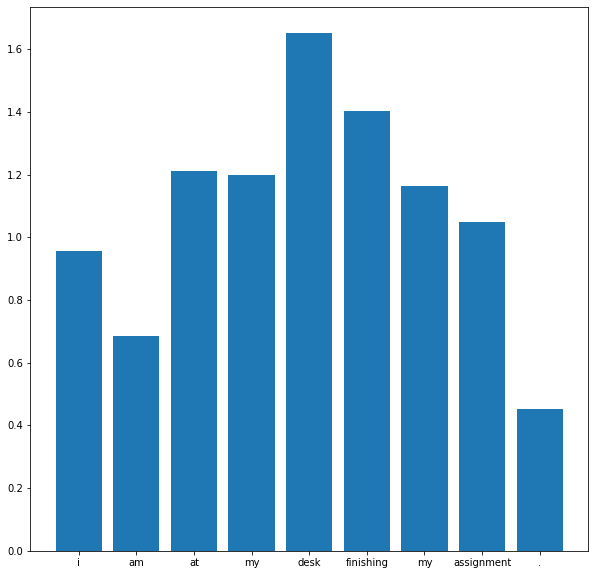

In [17]:
from evaluation.visualization import weights_plot

weights_plot(text_tokenizer(premise), max_pool_propensity(text_to_input(premise, vocab), maxpool)[0][1:-1])

The following gives the exact same figure, but only highlights the text (more succinct)

In [18]:
from evaluation.visualization import text_highlighter

display(text_highlighter(premise, max_pool_propensity(text_to_input(premise, vocab), maxpool)[0]))
display(text_highlighter(hypothesis, max_pool_propensity(text_to_input(hypothesis, vocab), maxpool)[0]))

## Error Analysis of BiLSTM w/ Maxpool
The only naked code in this notebook

### Worst of the worst

In [19]:
import pickle 

with open("./checkpoints/InferSent-BiMaxPool_v3/best_worst_loss.pkl", 'rb+') as file:
    best_worst_losses = pickle.load(file)

In [20]:
from torch.nn.utils.rnn import pad_sequence

losses = []
premise_texts = []
hypothesis_texts = []
true_labels = []
for (l, prem, hypo, lab) in best_worst_losses['worst']:
    losses.append(l)
    premise_texts.append(text_to_input(prem, vocab))
    hypothesis_texts.append(text_to_input(hypo, vocab))
    true_labels.append(lab)

premise_texts_ = pad_sequence(premise_texts, padding_value=vocab["<PAD>"]).squeeze()
hypothesis_texts_ = pad_sequence(hypothesis_texts, padding_value=vocab["<PAD>"]).squeeze()

input_output_table(premise_texts_, hypothesis_texts_, true_labels, maxpool, vocab, loss=losses, N=10)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,ski equipment sits alone on a snowy mountain,skis and boots are outside a ski lodge while the skiers enjoy a hot drink indoors .,2,0.000000,1.000000,0.000000,18.079325
1,a man is standing in front of a building holding heart shaped balloons and a woman is crossing the street .,someone is holding something heavy outside .,1,0.929906,0.000004,0.070090,16.559555
2,a young man trying to buy a car from his dealer after his old car was towed away by police .,a person renting a vehicle .,1,0.999518,0.000000,0.000482,16.040890
3,several women are playing volleyball .,this does n't look like soccer,0,0.000000,0.999996,0.000004,14.767435
4,swimming in the wide blue ocean .,the ocean swims in the blue wideness .,1,0.989514,0.000011,0.010475,13.331501
5,here are a bunch of people enjoying dinner and chatting .,our group is enjoying an early brunch .,1,0.006706,0.000033,0.993261,12.890605
6,a band performing at a local bar or club .,the band is playing music at a large venue,1,0.222308,0.000034,0.777657,12.865244
7,a man wearing a welding mask working on a duct .,the man is working underneath a vehicle .,1,0.998208,0.000018,0.001774,12.651140
8,"people are riding bicycles in the street , and they are all wearing helmets .","a group of friends are grabbing their bikes , getting ready for the morning bike ride",1,0.005034,0.000005,0.994961,12.611356
9,there is a man poking a long stick up towards the ceiling .,the man has no arms .,2,0.000002,0.999996,0.000003,12.196178


In [21]:
for i in [0, 5, 13, 23, 28, 35]:
    print('Rank {:}, true class {:}'.format(i, best_worst_losses['worst'][i][3]))
    display(text_highlighter(best_worst_losses['worst'][i][1], max_pool_propensity(premise_texts[i], maxpool)[0]))
    display(text_highlighter(best_worst_losses['worst'][i][2], max_pool_propensity(hypothesis_texts[i], maxpool)[0]))
    print('')

Rank 0, true class 2



Rank 5, true class 1



Rank 13, true class 0



Rank 23, true class 1



Rank 28, true class 1



Rank 35, true class 1


The errors made by the model are both impressive and dissapointing. Ultimately, what remains important to the BiLSTM \w maxpooling (much like the baseline) is word overlap. In sentences where this is not the case, it has a pronounced tendency to classifying as 'Neutral'. 

Most important to the model seems to be verb matching. If the verbs between the premise and hypothesis match (and their relative order), the model tends for 'Entailment', despite the subjects not matching. More on this later.

Otherwise, some truly difficult sentences are also present in the dataset, ones I expect humans to have difficulty with also without further context. 

### Best of the best

In [22]:
from torch.nn.utils.rnn import pad_sequence

losses = []
premise_texts = []
hypothesis_texts = []
true_labels = []
for (l, prem, hypo, lab) in best_worst_losses['best']:
    losses.append(l)
    premise_texts.append(text_to_input(prem, vocab))
    hypothesis_texts.append(text_to_input(hypo, vocab))
    true_labels.append(lab)

premise_texts_ = pad_sequence(premise_texts, padding_value=vocab["<PAD>"]).squeeze()
hypothesis_texts_ = pad_sequence(hypothesis_texts, padding_value=vocab["<PAD>"]).squeeze()

input_output_table(premise_texts_, hypothesis_texts_, true_labels, maxpool, vocab, loss=losses, N=10)

,Premise,Hypothesis,Label,p(f(x)=0),p(f(x)=1),p(f(x)=2),Loss
0,"in a snowy residential environment , a man with a brown jacket and gray mustache and beard places a hand on a felled log while another man in a blue shirt is blurry on the right side of the photo .",the men felled the log in a snowy area .,0,0.905096,0.013302,0.081602,-0.140916
1,boy wearing a blue hoodie jumps over a stair railing .,the girl sat on the bench .,1,0.000000,1.000000,0.000000,0.000000
2,dog herding cows,cats are sleeping inside the room .,1,0.000000,1.000000,0.000000,0.000000
3,fireworks light up the night as a man stands on stage .,the man is studying quietly in the house .,1,0.000000,1.000000,0.000000,0.000000
4,four dark - skinned boys are playing soccer .,the boy is eating a sandwich on the moon .,1,0.000000,1.000000,0.000000,0.000000
5,four dogs of varying breeds running through a field .,various dogs sleeping in a house .,1,0.000000,1.000000,0.000000,0.000000
6,four men in red vests with crosses on them ski on a mountain .,the friends are sitting in a coffee shop .,1,0.000000,1.000000,0.000000,0.000000
7,four older men are playing musical instruments in a park by a wall in traditional costume .,four young women are playing chess in the park .,1,0.000000,1.000000,0.000000,0.000000
8,group of men sitting at a table turn to have their picture taken .,the group of men are running around the street in different directions .,1,0.000000,1.000000,0.000000,0.000000
9,horses jumping a hurdle in a race .,a lion is eating a huge slab of raw meat .,1,0.000000,1.000000,0.000000,0.000000


Top loss is negative here because I needed to invert a heap.

In [23]:
for i in [1, 2, 8, 24]:
    print('Rank {:}, true class {:}'.format(i, best_worst_losses['best'][i][3]))
    display(text_highlighter(best_worst_losses['best'][i][1], max_pool_propensity(premise_texts[i], maxpool)[0]))
    display(text_highlighter(best_worst_losses['best'][i][2], max_pool_propensity(hypothesis_texts[i], maxpool)[0]))
    print('')

Rank 1, true class 1



Rank 2, true class 1



Rank 8, true class 1



Rank 24, true class 1


The best classifications are actually quite boring, with the model perfectly picking up on 'Contradiction'. These sentences have subjects that tend to agree or occur as antonyms. Beyond these, the verbs tend to disagree, and the model correctly picks up on disagreement between the sentences.

## Word-level Linguistic Preferences of InferSent
Some additional analysis using the maxpool selection propensity quantity (again, over random selection to be comparable between sentences), linked to Spacy's linguistic classes. This gives an indication for what the model likes and dislikes when it comes to individual words. This has been done for all of the hypotheses and premises in the validation and test sets.

Boxplot gives the distribution (whiskers go to 10th and 90th percentiles, boxes go to 25th and 75th, and line gives 50th/median). The little diamonds give the mean score. Rows (vertical) are the individual Spacy linguistic categories.

Coarse grained POS tags:

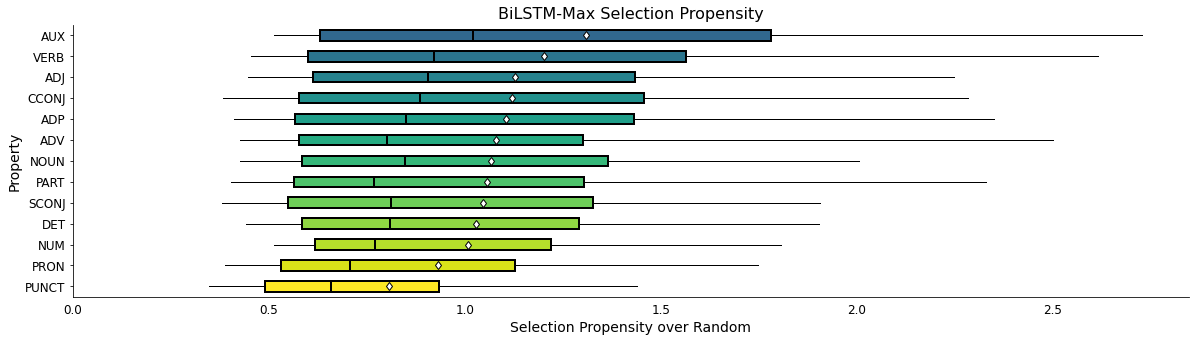

In [24]:
from evaluation.visualization import linguistic_properties_printer

linguistic_properties_printer(3, 'pos', figsize=(20, 5))

Preference for verbs, especially auxilliary verbs. Beyond these, adjectives and coordinating conjunctions, before plateauing.

Fine graind (Penn treebank, https://universaldependencies.org/tagset-conversion/en-penn-uposf.html) UPOS tags:

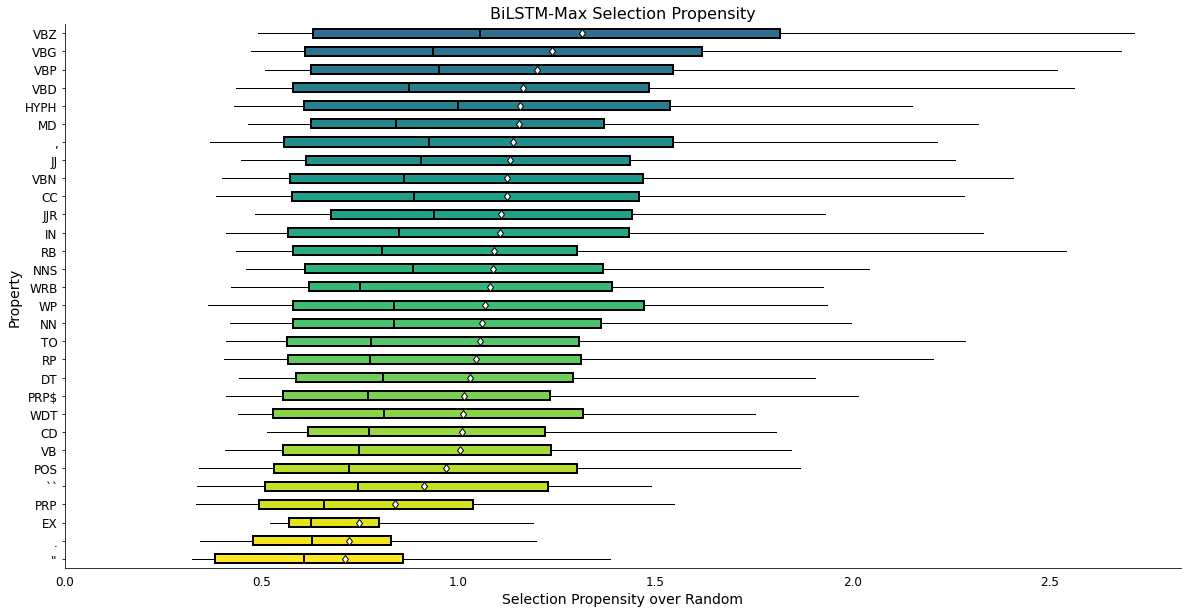

In [25]:
linguistic_properties_printer(3, 'tag', figsize=(20, 10))

Same as above, strong preference for verbs of all forms. Interestingly, the punctuation that can function as conjuctions ('-' and ',') also score very high. In contrast, all other punctuation scores very low.

Dependency relationships of the words (UD, https://universaldependencies.org/docs/en/dep/):

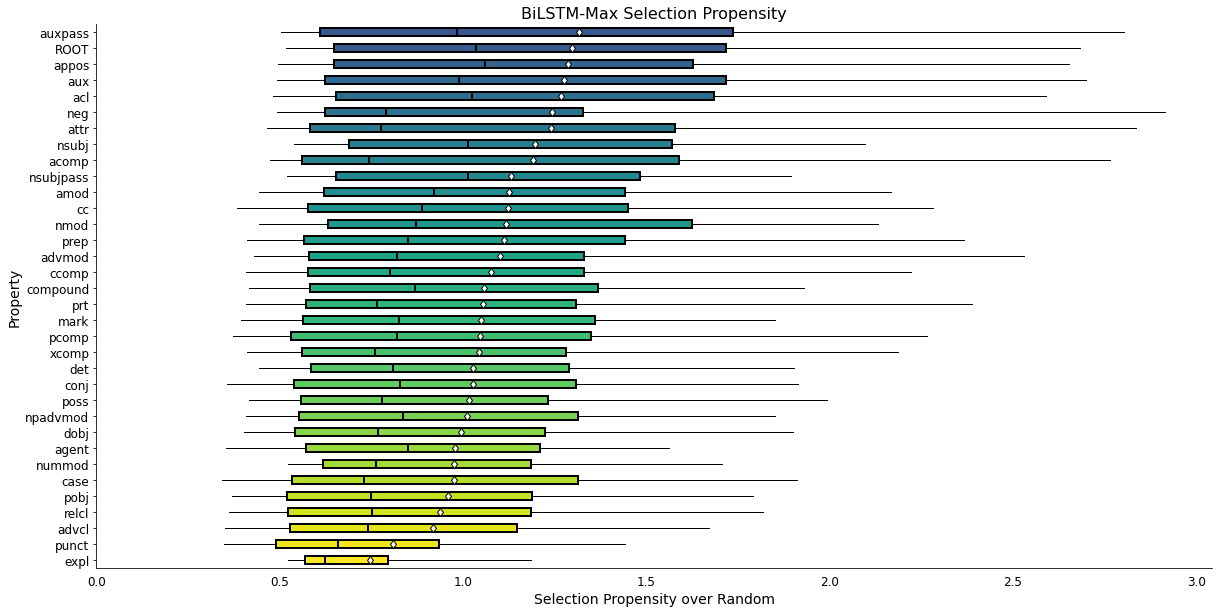

In [26]:
linguistic_properties_printer(3, 'dep', figsize=(20, 10))

Again auxilliary phrases tend to score high. However, ROOT tends to score high as well, showing some incorporation of the semantic head of a sentence. Beyond these, the 'appos' and 'acl' modifiers score high as well, showing the model picks up on relevant clauses that reference back to important quantities. Lastly, the means of the 'neg' and 'attr' properties indicate that these properties sometimes are important to the model, but not always (low medians). These are again important semantic markers.

Whether or not the word is in an entity phrase (not really interesting, or significant):

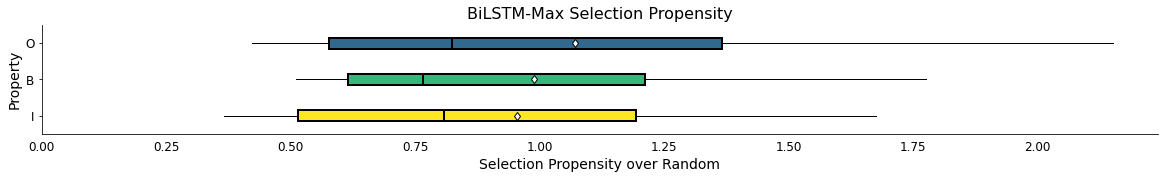

In [27]:
linguistic_properties_printer(3, 'iob', figsize=(20, 2))

No big difference here.

# Short Summary

This project sees 4 different models implemented for generating general-purpose sentence embeddings. The first simply leverages word embeddings to create an averaged embedding over a sequence of words. While simple (hence a baseline), and achieving poor performance on the main task, it proves to be a formidable opponent when it comes to the semantic transfer and probing tasks in SentEval. 

Models 2 and 3 are uni- and bidirectional LSTMs. Here the sentence embeddings come from the final hidden state, theoretically containing all information within a sentence after having processed it in their entirety. While performance on the main task proved adequate, unlike the baseline model, performance took a nosedive when being applied to new domains. Personally, I believe these models to be too strong for task-specific prediction to function as general sentence embedders. The initial training passes gradients through to the LSTMs, allowing it to learn to 'forget' or 'incorporate' aspects of the sentence, relevant to the final task. The final state is then highly succesful for predicting SNLI labels, but likely has neglected considerable amounts of other information.

The final model, BiLSTM \w maxpooling or InferSent, wins on virtually all tasks. When compared to the LSTM architectures, its performance on SNLI is slightly better, but when extending to SentEval tasks, it becomes abudantly clear that the InferSent embeddings contain far more general information relevant for semantic processing. One possible explanation can be found in the training curves: maxpooling induces much faster traing, likely due to 'residual' connections between the entire sequence and final prediction. Not only is accuracy immediately much higher, the loss also plateaus faster, indicating rapid convergence to (local) minima. Another explanation might be that maxpooling forces concrete decisions of the model as to which semantic properties to keep and which to discard, whereas the other models are allowed to be more ambiguous towards sentence representations \[1].

Yet, when futher analysing InferSent, its performance becomes less impressive. For example, on the probing tasks, while it retains strong performance, this is primarily on the lower levels of the linguistic pyramid. When considering high-level semantic tasks, it falls back to accuracies scarily close to those of the baseline model. While this testifies to the strength of word embeddings, one would expect much better for such a (relatively) large model. 

Error analysis, and analysis of the linguistic features of the word-level maxpooling propensity, give some hints as to the limitations of InferSent (trained for NLI). English, and the SNLI sentences, tends to be a very Subject-Verb-Object language, and it seems InferSent picks up on this. Its primary feature seems to be find verbs, or other connecting structures, between clauses in a sentence, and compare the premise and hypothesis on how well these overlap (this is an overgeneralization). Sentences where the verbs are not overlapping, or where these refer to different antecedents, are overrepresented in the missclassifications. In other words, InferSent or perhaps SNLI, is lazy; it learns to check whether clauses between sentences agree or disagree, but not the actual semantic content of those sentences.

An interesting perspective on all of this is provided by other researchers at Facebook AI \[3]. They show that a random model, although ones that retain the inductive bias, on top of word embeddings already perform at or even above InferSent on 
the majority of SentEval tasks. Crucially, the hidden dimension has the biggest impact on classification performance. Thus, when one wants to build a sentence embedder, but is in doubt, taking word representations and projecting to a high-dimensional space (e.g. 4096), seems to be a very good place to start.

Just under 1 page.

# References
\[1] Conneau, A., Kiela, D., Schwenk, H., Barrault, L., & Bordes, A. (2017). Supervised learning of universal sentence representations from natural language inference data. arXiv preprint arXiv:1705.02364.

\[2] Conneau, A., Kruszewski, G., Lample, G., Barrault, L., & Baroni, M. (2018). What you can cram into a single vector: Probing sentence embeddings for linguistic properties. arXiv preprint arXiv:1805.01070.

\[3] Wieting, J., & Kiela, D. (2019). No training required: Exploring random encoders for sentence classification. arXiv preprint arXiv:1901.10444.